<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">

# Artificial Intelligence in Finance

## AI-First Finance

Dr Yves J Hilpisch | The AI Machine

http://aimachine.io | http://twitter.com/dyjh

## Efficient Markets

In [1]:
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('precision', 4)
np.set_printoptions(suppress=True, precision=4)

In [2]:
url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'

In [3]:
data = pd.read_csv(url, index_col=0, parse_dates=True).dropna()

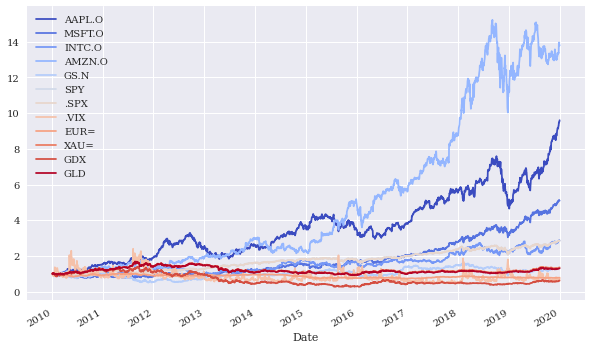

In [4]:
(data / data.iloc[0]).plot(figsize=(10, 6), cmap='coolwarm');

In [5]:
lags = 7

In [6]:
def add_lags(data, ric, lags):
    cols = []
    df = pd.DataFrame(data[ric])
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        df[col] = df[ric].shift(lag)
        cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [7]:
dfs = {}
for sym in data.columns:
    df, cols = add_lags(data, sym, lags)
    dfs[sym] = df

In [8]:
dfs[sym].head(7)

,GLD,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,
2010-01-13,111.54,110.49,112.85,111.37,110.82,111.51,109.70,109.80
2010-01-14,112.03,111.54,110.49,112.85,111.37,110.82,111.51,109.70
2010-01-15,110.86,112.03,111.54,110.49,112.85,111.37,110.82,111.51
2010-01-19,111.52,110.86,112.03,111.54,110.49,112.85,111.37,110.82
2010-01-20,108.94,111.52,110.86,112.03,111.54,110.49,112.85,111.37
2010-01-21,107.37,108.94,111.52,110.86,112.03,111.54,110.49,112.85
2010-01-22,107.17,107.37,108.94,111.52,110.86,112.03,111.54,110.49


In [9]:
regs = {}
for sym in data.columns:
    df = dfs[sym]
    reg = np.linalg.lstsq(df[cols], df[sym], rcond=-1)[0]
    regs[sym] = reg

In [10]:
rega = np.stack(tuple(regs.values()))

In [11]:
regd = pd.DataFrame(rega, columns=cols, index=data.columns)

In [12]:
regd

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
AAPL.O,1.0106,-0.0592,0.0258,0.0535,-0.0172,0.0060,-0.0184
MSFT.O,0.8928,0.0112,0.1175,-0.0832,-0.0258,0.0567,0.0323
INTC.O,0.9519,0.0579,0.0490,-0.0772,-0.0373,0.0449,0.0112
AMZN.O,0.9799,-0.0134,0.0206,0.0007,0.0525,-0.0452,0.0056
GS.N,0.9806,0.0342,-0.0172,0.0042,-0.0387,0.0585,-0.0215
SPY,0.9692,0.0067,0.0228,-0.0244,-0.0237,0.0379,0.0121
.SPX,0.9672,0.0106,0.0219,-0.0252,-0.0318,0.0515,0.0063
.VIX,0.8823,0.0591,-0.0289,0.0284,-0.0256,0.0511,0.0306
EUR=,0.9859,0.0239,-0.0484,0.0508,-0.0217,0.0149,-0.0055
XAU=,0.9864,0.0069,0.0166,-0.0215,0.0044,0.0198,-0.0125


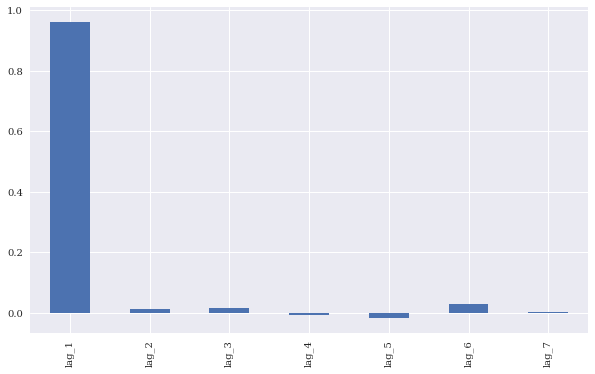

In [13]:
regd.mean().plot(kind='bar', figsize=(10, 6));

In [14]:
dfs[sym].corr()

,GLD,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
GLD,1.0000,0.9972,0.9946,0.9920,0.9893,0.9867,0.9841,0.9815
lag_1,0.9972,1.0000,0.9972,0.9946,0.9920,0.9893,0.9867,0.9842
lag_2,0.9946,0.9972,1.0000,0.9972,0.9946,0.9920,0.9893,0.9867
lag_3,0.9920,0.9946,0.9972,1.0000,0.9972,0.9946,0.9920,0.9893
lag_4,0.9893,0.9920,0.9946,0.9972,1.0000,0.9972,0.9946,0.9920
lag_5,0.9867,0.9893,0.9920,0.9946,0.9972,1.0000,0.9972,0.9946
lag_6,0.9841,0.9867,0.9893,0.9920,0.9946,0.9972,1.0000,0.9972
lag_7,0.9815,0.9842,0.9867,0.9893,0.9920,0.9946,0.9972,1.0000


In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
adfuller(data[sym].dropna())

(-1.9488969577009954,
 0.3094193074034718,
 0,
 2515,
 {'1%': -3.4329527780962255,
  '5%': -2.8626898965523724,
  '10%': -2.567382133955709},
 8446.683102944744)

## Market Prediction Based on Returns Data

In [17]:
rets = np.log(data / data.shift(1))

In [18]:
rets.dropna(inplace=True)

In [19]:
dfs = {}
for sym in data:
    df, cols = add_lags(rets, sym, lags)
    mu, std = df[cols].mean(), df[cols].std()
    df[cols] = (df[cols] - mu) / std
    dfs[sym] = df

In [20]:
dfs[sym].head()

,GLD,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,
2010-01-14,0.0044,0.9570,-2.1692,1.3386,0.4959,-0.6434,1.6613,-0.1028
2010-01-15,-0.0105,0.4379,0.9571,-2.1689,1.3388,0.4966,-0.6436,1.6614
2010-01-19,0.0059,-1.0842,0.4385,0.9562,-2.1690,1.3395,0.4958,-0.6435
2010-01-20,-0.0234,0.5967,-1.0823,0.4378,0.9564,-2.1686,1.3383,0.4958
2010-01-21,-0.0145,-2.4045,0.5971,-1.0825,0.4379,0.9571,-2.1680,1.3384


In [21]:
adfuller(dfs[sym]['lag_1'])

(-51.568251505825536,
 0.0,
 0,
 2507,
 {'1%': -3.4329610922579095,
  '5%': -2.8626935681060375,
  '10%': -2.567384088736619},
 7017.165474260225)

In [22]:
dfs[sym].corr()

,GLD,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
GLD,1.0000,-0.0297,0.0003,1.2635e-02,-0.0026,-5.9392e-03,0.0099,-0.0013
lag_1,-0.0297,1.0000,-0.0305,8.1418e-04,0.0128,-2.8765e-03,-0.0053,0.0098
lag_2,0.0003,-0.0305,1.0000,-3.1617e-02,0.0003,1.3234e-02,-0.0043,-0.0052
lag_3,0.0126,0.0008,-0.0316,1.0000e+00,-0.0313,-6.8542e-06,0.0141,-0.0044
lag_4,-0.0026,0.0128,0.0003,-3.1329e-02,1.0000,-3.1761e-02,0.0002,0.0141
lag_5,-0.0059,-0.0029,0.0132,-6.8542e-06,-0.0318,1.0000e+00,-0.0323,0.0002
lag_6,0.0099,-0.0053,-0.0043,1.4115e-02,0.0002,-3.2289e-02,1.0000,-0.0324
lag_7,-0.0013,0.0098,-0.0052,-4.3869e-03,0.0141,2.1707e-04,-0.0324,1.0000


In [23]:
from sklearn.metrics import accuracy_score

In [24]:
%%time
for sym in data:
    df = dfs[sym]
    reg = np.linalg.lstsq(df[cols], df[sym], rcond=-1)[0]
    pred = np.dot(df[cols], reg)
    acc = accuracy_score(np.sign(df[sym]), np.sign(pred))
    print(f'OLS | {sym:10s} | acc={acc:.4f}')

OLS | AAPL.O     | acc=0.5056
OLS | MSFT.O     | acc=0.5088
OLS | INTC.O     | acc=0.5040
OLS | AMZN.O     | acc=0.5048
OLS | GS.N       | acc=0.5080
OLS | SPY        | acc=0.5080
OLS | .SPX       | acc=0.5167
OLS | .VIX       | acc=0.5291
OLS | EUR=       | acc=0.4984
OLS | XAU=       | acc=0.5207
OLS | GDX        | acc=0.5307
OLS | GLD        | acc=0.5072
CPU times: user 107 ms, sys: 35.7 ms, total: 143 ms
Wall time: 41.8 ms


In [25]:
from sklearn.neural_network import MLPRegressor

In [26]:
%%time
for sym in data.columns:
    df = dfs[sym]
    model = MLPRegressor(hidden_layer_sizes=[512],
                         random_state=100,
                         max_iter=1000,
                         early_stopping=True,
                         validation_fraction=0.15,
                         shuffle=False)
    model.fit(df[cols], df[sym])
    pred = model.predict(df[cols])
    acc = accuracy_score(np.sign(df[sym]), np.sign(pred))
    print(f'MLP | {sym:10s} | acc={acc:.4f}')

MLP | AAPL.O     | acc=0.6005
MLP | MSFT.O     | acc=0.5853
MLP | INTC.O     | acc=0.5766
MLP | AMZN.O     | acc=0.5510
MLP | GS.N       | acc=0.6527
MLP | SPY        | acc=0.5419
MLP | .SPX       | acc=0.5399
MLP | .VIX       | acc=0.6579
MLP | EUR=       | acc=0.5642
MLP | XAU=       | acc=0.5522
MLP | GDX        | acc=0.6029
MLP | GLD        | acc=0.5259
CPU times: user 39 s, sys: 8.9 s, total: 47.9 s
Wall time: 13.4 s


In [27]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential

In [28]:
np.random.seed(100)
tf.random.set_seed(100)

In [29]:
def create_model(problem='regression'):
    model = Sequential()
    model.add(Dense(512, input_dim=len(cols),
                    activation='relu'))
    if problem == 'regression':
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mse', optimizer='adam')
    else:
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [30]:
%%time
for sym in data.columns[:]:
    df = dfs[sym]
    model = create_model()
    model.fit(df[cols], df[sym], epochs=25, verbose=False)
    pred = model.predict(df[cols])
    acc = accuracy_score(np.sign(df[sym]), np.sign(pred))
    print(f'DNN | {sym:10s} | acc={acc:.4f}')

DNN | AAPL.O     | acc=0.6085
DNN | MSFT.O     | acc=0.6152
DNN | INTC.O     | acc=0.6236
DNN | AMZN.O     | acc=0.6276
DNN | GS.N       | acc=0.6136
DNN | SPY        | acc=0.5594
DNN | .SPX       | acc=0.5478
DNN | .VIX       | acc=0.6148
DNN | EUR=       | acc=0.5817
DNN | XAU=       | acc=0.6021
DNN | GDX        | acc=0.6120
DNN | GLD        | acc=0.6001
CPU times: user 33.6 s, sys: 10.2 s, total: 43.8 s
Wall time: 22.9 s


In [31]:
split = int(len(dfs[sym]) * 0.8)

In [32]:
%%time
for sym in data.columns:
    df = dfs[sym]
    train = df.iloc[:split]
    reg = np.linalg.lstsq(train[cols], train[sym], rcond=-1)[0]
    test = df.iloc[split:]
    pred = np.dot(test[cols], reg)
    acc = accuracy_score(np.sign(test[sym]), np.sign(pred))
    print(f'OLS | {sym:10s} | acc={acc:.4f}')

OLS | AAPL.O     | acc=0.5219
OLS | MSFT.O     | acc=0.4960
OLS | INTC.O     | acc=0.5418
OLS | AMZN.O     | acc=0.4841
OLS | GS.N       | acc=0.4980
OLS | SPY        | acc=0.5020
OLS | .SPX       | acc=0.5120
OLS | .VIX       | acc=0.5458
OLS | EUR=       | acc=0.4482
OLS | XAU=       | acc=0.5299
OLS | GDX        | acc=0.5159
OLS | GLD        | acc=0.5100
CPU times: user 76.7 ms, sys: 16 ms, total: 92.7 ms
Wall time: 73.3 ms


In [33]:
%%time
for sym in data.columns:
    df = dfs[sym]
    train = df.iloc[:split]
    model = MLPRegressor(hidden_layer_sizes=[512],
                         random_state=100,
                         max_iter=1000,
                         early_stopping=True,
                         validation_fraction=0.15,
                         shuffle=False)
    model.fit(train[cols], train[sym])
    test = df.iloc[split:]
    pred = model.predict(test[cols])
    acc = accuracy_score(np.sign(test[sym]), np.sign(pred))
    print(f'MLP | {sym:10s} | acc={acc:.4f}')

MLP | AAPL.O     | acc=0.4920
MLP | MSFT.O     | acc=0.5279
MLP | INTC.O     | acc=0.5279
MLP | AMZN.O     | acc=0.4641
MLP | GS.N       | acc=0.5040
MLP | SPY        | acc=0.5259
MLP | .SPX       | acc=0.5478
MLP | .VIX       | acc=0.5279
MLP | EUR=       | acc=0.4980
MLP | XAU=       | acc=0.5239
MLP | GDX        | acc=0.4880
MLP | GLD        | acc=0.5000
CPU times: user 35.7 s, sys: 8.88 s, total: 44.6 s
Wall time: 14.5 s


In [34]:
%%time
for sym in data.columns:
    df = dfs[sym]
    train = df.iloc[:split]
    model = create_model()
    model.fit(train[cols], train[sym], epochs=50, verbose=False)
    test = df.iloc[split:]
    pred = model.predict(test[cols])
    acc = accuracy_score(np.sign(test[sym]), np.sign(pred))
    print(f'DNN | {sym:10s} | acc={acc:.4f}')

DNN | AAPL.O     | acc=0.4522
DNN | MSFT.O     | acc=0.5040
DNN | INTC.O     | acc=0.4900
DNN | AMZN.O     | acc=0.5000
DNN | GS.N       | acc=0.5259
DNN | SPY        | acc=0.5398
DNN | .SPX       | acc=0.5339
DNN | .VIX       | acc=0.5020
DNN | EUR=       | acc=0.5060
DNN | XAU=       | acc=0.4861
DNN | GDX        | acc=0.4761
DNN | GLD        | acc=0.4880
CPU times: user 41.2 s, sys: 13.2 s, total: 54.4 s
Wall time: 25 s


## Market Prediction With More Features

In [35]:
url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'

In [36]:
data = pd.read_csv(url, index_col=0, parse_dates=True).dropna()

In [37]:
def add_lags(data, ric, lags, window=50):
    cols = []
    df = pd.DataFrame(data[ric])
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift())
    df['sma'] = df[ric].rolling(window).mean()
    df['min'] = df[ric].rolling(window).min()
    df['max'] = df[ric].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = [ric, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [38]:
lags = 5

In [39]:
dfs = {}
for ric in data:
    df, cols = add_lags(data, ric, lags)
    dfs[ric] = df.dropna(), cols

In [40]:
len(cols)

40

In [41]:
from sklearn.neural_network import MLPClassifier

In [42]:
%%time
for ric in data:
    model = MLPClassifier(hidden_layer_sizes=[512],
                          random_state=100,
                          max_iter=1000,
                          early_stopping=True,
                          validation_fraction=0.15,
                          shuffle=False)
    df, cols = dfs[ric]
    df[cols] = (df[cols] - df[cols].mean()) / df[cols].std()
    model.fit(df[cols], df['d'])
    pred = model.predict(df[cols])
    acc = accuracy_score(df['d'], pred)
    print(f'IN-SAMPLE | {ric:7s} | acc={acc:.4f}')

IN-SAMPLE | AAPL.O  | acc=0.5510
IN-SAMPLE | MSFT.O  | acc=0.5376
IN-SAMPLE | INTC.O  | acc=0.5607
IN-SAMPLE | AMZN.O  | acc=0.5559
IN-SAMPLE | GS.N    | acc=0.5794
IN-SAMPLE | SPY     | acc=0.5729
IN-SAMPLE | .SPX    | acc=0.5941
IN-SAMPLE | .VIX    | acc=0.6940
IN-SAMPLE | EUR=    | acc=0.5766
IN-SAMPLE | XAU=    | acc=0.5672
IN-SAMPLE | GDX     | acc=0.5847
IN-SAMPLE | GLD     | acc=0.5567
CPU times: user 24.1 s, sys: 5.59 s, total: 29.7 s
Wall time: 8.3 s


In [43]:
%%time
for ric in data:
    model = create_model('classification')
    df, cols = dfs[ric]
    df[cols] = (df[cols] - df[cols].mean()) / df[cols].std()
    model.fit(df[cols], df['d'], epochs=50, verbose=False)
    pred = np.where(model.predict(df[cols]) > 0.5, 1, 0)
    acc = accuracy_score(df['d'], pred)
    print(f'IN-SAMPLE | {ric:7s} | acc={acc:.4f}')

IN-SAMPLE | AAPL.O  | acc=0.7005
IN-SAMPLE | MSFT.O  | acc=0.6973
IN-SAMPLE | INTC.O  | acc=0.6928
IN-SAMPLE | AMZN.O  | acc=0.6741
IN-SAMPLE | GS.N    | acc=0.6932
IN-SAMPLE | SPY     | acc=0.6818
IN-SAMPLE | .SPX    | acc=0.6904
IN-SAMPLE | .VIX    | acc=0.7383
IN-SAMPLE | EUR=    | acc=0.6826
IN-SAMPLE | XAU=    | acc=0.6997
IN-SAMPLE | GDX     | acc=0.6851
IN-SAMPLE | GLD     | acc=0.6985
CPU times: user 1min 14s, sys: 20.9 s, total: 1min 35s
Wall time: 49.8 s


In [44]:
def train_test_model(model):
    for ric in data:
        df, cols = dfs[ric]
        split = int(len(df) * 0.85)
        train = df.iloc[:split].copy()
        mu, std = train[cols].mean(), train[cols].std()
        train[cols] = (train[cols] - mu) / std
        model.fit(train[cols], train['d'])
        test = df.iloc[split:].copy() 
        test[cols] = (test[cols] - mu) / std
        pred = model.predict(test[cols])
        acc = accuracy_score(test['d'], pred)
        print(f'OUT-OF-SAMPLE | {ric:7s} | acc={acc:.4f}')

In [45]:
model_mlp = MLPClassifier(hidden_layer_sizes=[512],
                          random_state=100,
                          max_iter=1000,
                          early_stopping=True,
                          validation_fraction=0.15,
                          shuffle=False)

In [46]:
%time train_test_model(model_mlp)

OUT-OF-SAMPLE | AAPL.O  | acc=0.4432
OUT-OF-SAMPLE | MSFT.O  | acc=0.4595
OUT-OF-SAMPLE | INTC.O  | acc=0.5000
OUT-OF-SAMPLE | AMZN.O  | acc=0.5270
OUT-OF-SAMPLE | GS.N    | acc=0.4838
OUT-OF-SAMPLE | SPY     | acc=0.4811
OUT-OF-SAMPLE | .SPX    | acc=0.5027
OUT-OF-SAMPLE | .VIX    | acc=0.5676
OUT-OF-SAMPLE | EUR=    | acc=0.4649
OUT-OF-SAMPLE | XAU=    | acc=0.5514
OUT-OF-SAMPLE | GDX     | acc=0.5162
OUT-OF-SAMPLE | GLD     | acc=0.4946
CPU times: user 16.2 s, sys: 4.61 s, total: 20.8 s
Wall time: 7.33 s


In [47]:
from sklearn.ensemble import BaggingClassifier

In [48]:
base_estimator = MLPClassifier(hidden_layer_sizes=[256],
                          random_state=100,
                          max_iter=1000,
                          early_stopping=True,
                          validation_fraction=0.15,
                          shuffle=False)

In [49]:
model_bag = BaggingClassifier(base_estimator=base_estimator,
                          n_estimators=35,
                          max_samples=0.25,
                          max_features=0.5,
                          bootstrap=False,
                          bootstrap_features=True,
                          n_jobs=8,
                          random_state=100
                         )

In [50]:
%time train_test_model(model_bag)

OUT-OF-SAMPLE | AAPL.O  | acc=0.5000
OUT-OF-SAMPLE | MSFT.O  | acc=0.5703
OUT-OF-SAMPLE | INTC.O  | acc=0.5054
OUT-OF-SAMPLE | AMZN.O  | acc=0.5270
OUT-OF-SAMPLE | GS.N    | acc=0.5135
OUT-OF-SAMPLE | SPY     | acc=0.5568
OUT-OF-SAMPLE | .SPX    | acc=0.5514
OUT-OF-SAMPLE | .VIX    | acc=0.5432
OUT-OF-SAMPLE | EUR=    | acc=0.5054
OUT-OF-SAMPLE | XAU=    | acc=0.5351
OUT-OF-SAMPLE | GDX     | acc=0.5054
OUT-OF-SAMPLE | GLD     | acc=0.5189
CPU times: user 1.66 s, sys: 543 ms, total: 2.2 s
Wall time: 15.7 s


## Market Prediction Intraday

In [51]:
url = 'http://hilpisch.com/aiif_eikon_id_data.csv'

In [52]:
data = pd.read_csv(url, index_col=0, parse_dates=True) # .dropna()

In [53]:
data.tail()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2019-12-31 20:00:00,292.36,157.2845,59.575,1845.22,228.92,320.94,3219.75,14.16,1.1215,1519.6451,29.40,143.12
2019-12-31 21:00:00,293.37,157.4900,59.820,1846.95,229.89,321.89,3230.56,13.92,1.1216,1517.3600,29.29,142.93
2019-12-31 22:00:00,293.82,157.9000,59.990,1850.20,229.93,322.39,3230.78,13.78,1.1210,1517.0100,29.30,142.90
2019-12-31 23:00:00,293.75,157.8300,59.910,1851.00,NaN,322.22,NaN,NaN,1.1211,1516.8900,29.40,142.88
2020-01-01 00:00:00,293.81,157.8800,59.870,1850.10,NaN,322.32,NaN,NaN,1.1211,NaN,29.34,143.00


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5529 entries, 2019-03-01 00:00:00 to 2020-01-01 00:00:00
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  3384 non-null   float64
 1   MSFT.O  3378 non-null   float64
 2   INTC.O  3275 non-null   float64
 3   AMZN.O  3381 non-null   float64
 4   GS.N    1686 non-null   float64
 5   SPY     3388 non-null   float64
 6   .SPX    1802 non-null   float64
 7   .VIX    2959 non-null   float64
 8   EUR=    5429 non-null   float64
 9   XAU=    5149 non-null   float64
 10  GDX     3173 non-null   float64
 11  GLD     3351 non-null   float64
dtypes: float64(12)
memory usage: 561.5 KB


In [55]:
lags = 5

In [56]:
dfs = {}
for ric in data:
    df, cols = add_lags(data, ric, lags)
    dfs[ric] = df, cols

In [57]:
%time train_test_model(model_mlp)

OUT-OF-SAMPLE | AAPL.O  | acc=0.5420
OUT-OF-SAMPLE | MSFT.O  | acc=0.4930
OUT-OF-SAMPLE | INTC.O  | acc=0.5549
OUT-OF-SAMPLE | AMZN.O  | acc=0.4709
OUT-OF-SAMPLE | GS.N    | acc=0.5184
OUT-OF-SAMPLE | SPY     | acc=0.4860
OUT-OF-SAMPLE | .SPX    | acc=0.5019
OUT-OF-SAMPLE | .VIX    | acc=0.4885
OUT-OF-SAMPLE | EUR=    | acc=0.5130
OUT-OF-SAMPLE | XAU=    | acc=0.4824
OUT-OF-SAMPLE | GDX     | acc=0.4765
OUT-OF-SAMPLE | GLD     | acc=0.5455
CPU times: user 23.3 s, sys: 6.52 s, total: 29.8 s
Wall time: 11.6 s


In [58]:
%time train_test_model(model_bag)

OUT-OF-SAMPLE | AAPL.O  | acc=0.5660
OUT-OF-SAMPLE | MSFT.O  | acc=0.5551
OUT-OF-SAMPLE | INTC.O  | acc=0.5072
OUT-OF-SAMPLE | AMZN.O  | acc=0.4830
OUT-OF-SAMPLE | GS.N    | acc=0.5020
OUT-OF-SAMPLE | SPY     | acc=0.4680
OUT-OF-SAMPLE | .SPX    | acc=0.4677
OUT-OF-SAMPLE | .VIX    | acc=0.5161
OUT-OF-SAMPLE | EUR=    | acc=0.5242
OUT-OF-SAMPLE | XAU=    | acc=0.5229
OUT-OF-SAMPLE | GDX     | acc=0.5107
OUT-OF-SAMPLE | GLD     | acc=0.5475
CPU times: user 1.94 s, sys: 572 ms, total: 2.51 s
Wall time: 19.4 s


<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">

<br><br><br><a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:ai@tpq.io">ai@tpq.io</a>